# Alpha lifetime

An script to compute alpha lifetime.

In [1]:
from __future__ import print_function, division
%load_ext autoreload
%autoreload 2
import sys
import os
import operator
import functools
import textwrap
import copy
import time
import glob
import math
print("Running on ", time.asctime())

import textwrap
import numpy as np
import pandas as pd
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

from invisible_cities.database import load_db
import invisible_cities.core.system_of_units_c as SystemOfUnits
from invisible_cities.core.core_functions import timefunc, flat
import invisible_cities.core.fit_functions as fitf
import invisible_cities.core.mpl_functions as mpl
from invisible_cities.core.mpl_functions import plot_pmt_waveforms, plot_pmt_signals_vs_time_mus, \
              plot_signal_vs_time_mus
from invisible_cities.core.core_functions import in_range

import invisible_cities.reco.tbl_functions as tbl
from invisible_cities.reco.pmaps_functions import plot_s12, width, integrate_charge
import invisible_cities.reco.pmaps_functions as pmapf
from invisible_cities.reco.params import S12Params, ThresholdParams


sys.path.append('/Users/alej/Desktop/Valencia/nextic/ICARO')

from icaro.core.event_pmaps import EventPmaps, print_s12, print_s2si
from icaro.core.hst_functions import labels, hist, doublehist, hist2d, pdf, scatter, profile_and_scatter,\
                              doublescatter, covariance, reso, gausstext, plot_profile_histogram 
from icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, print_fit, chi2


from scipy.optimize import curve_fit
from icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, \
                               profile_and_fit_radial, print_fit, MapXY, chi2,\
                               time_from_timestamp, lifetime

pi = np.pi



Running on  Wed Apr 19 23:37:33 2017


In [2]:
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-04-19 23:37:35


In [3]:
def plot_options(figsize=(6,6), fontsize=15):
    plt.rcParams["figure.figsize"]          = figsize
    plt.rcParams["font.size"]               = fontsize
    plt.rcParams["figure.max_open_warning"] = 100

In [4]:
plt.rcParams["figure.figsize"]          = 6, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

In [5]:
KDST = {3724:'LSC/kdst/3724/dst_3724.root.h5'}



### Run Parameters

In [6]:
run_number = 3724

In [7]:
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values

In [7]:
#ifile = os.path.join(os.environ['IC_DATA'],
#                        'LSC/kdst/{}/kdst_3628_full.h5'.format(run_number))

ifile = os.path.join(os.environ['IC_DATA'], KDST[3724])
                       
print("ifile:", ifile)

ifile: /Users/alej/Desktop/IC_DATA/LSC/kdst/3724/dst_3724.root.h5


In [8]:
full = load_dst(ifile)
print(len(full))
full.head()

9274


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,2,1.492629e+09,0,1,300.0,257.169556,1445.261420,619775.0,5.734750,27414.066406,...,652537.5,21,32.7625,32.7625,14.857671,74.967245,76.425377,1.375143,9.067780,9.211301
1,3,1.492629e+09,0,1,325.0,335.472260,1914.238391,239025.0,22.973312,6556.833496,...,655537.5,10,416.5125,416.5125,-20.948417,-115.492549,117.377021,-1.750229,9.022935,7.276593
2,6,1.492629e+09,0,1,325.0,323.425995,1898.150140,231275.0,13.020000,4850.539551,...,655812.5,14,424.5375,424.5375,21.538285,123.154987,125.024191,1.397660,9.513883,8.986937
3,7,1.492629e+09,0,1,300.0,334.545593,1886.497203,314775.0,9.877688,1658.268311,...,655212.5,6,340.4375,340.4375,-202.734094,-27.883778,204.642659,-3.004912,5.855626,6.180626
4,8,1.492629e+09,0,1,325.0,327.643494,1884.750703,309525.0,11.886688,5864.242188,...,656112.5,17,346.5875,346.5875,46.014973,123.390403,131.691190,1.213849,9.299893,9.999754


In [9]:
len(full)

9274

In [10]:
r = event_rate(full)

In [11]:
print("Trigger rate: {} evts/s".format(r))

Trigger rate: 4.528262824737751 evts/s


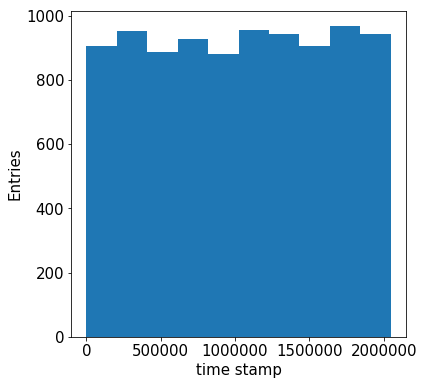

In [12]:
n, bins, patches = plt.hist(1e+3*(full.time - full.time[0]), 10)
labels("time stamp", "Entries")

In [13]:
st = [datetime.datetime.fromtimestamp(elem).strftime('%Y-%m-%d %H:%M:%S') for elem in full.time]
x = [datetime.datetime.strptime(elem, '%Y-%m-%d %H:%M:%S') for elem in st]

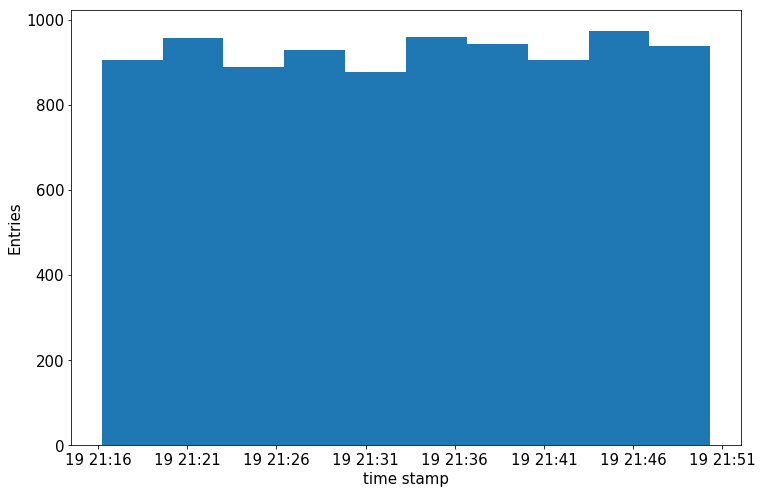

In [14]:
figsize=(12,8)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 1, 1)
nx, bx, _ = plt.hist(x, 10)
labels("time stamp", "Entries")

In [15]:
st = datetime.datetime.fromtimestamp(full.time[-1:]).strftime('%Y-%m-%d %H:%M:%S')

In [16]:
print(st)

2017-04-19 21:50:20


In [17]:
print(full.time.index[-1])

9273


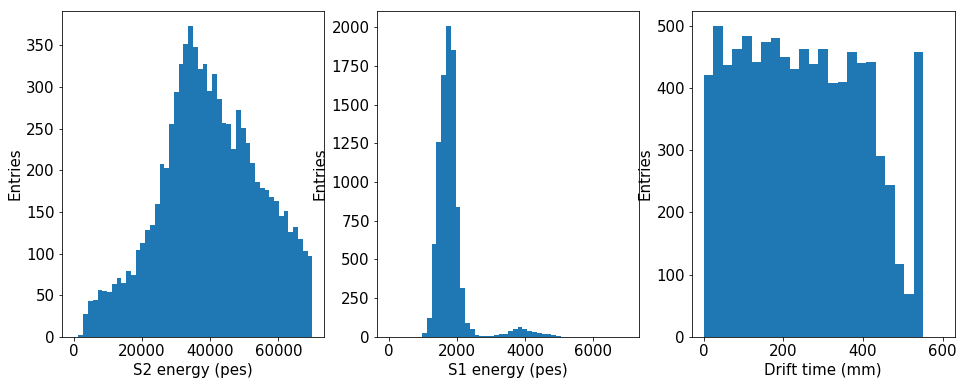

In [18]:
figsize=(16,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist(full.S2e, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")

ax = plt.subplot(1, 3, 2)
plt.hist(full.S1e, 50, (0e3,7e3))
labels("S1 energy (pes)", "Entries")

ax = plt.subplot(1, 3, 3)
plt.hist(full.Z, 25, (0,600))
labels("Drift time (mm)", "Entries")


### Dependence with Z all alphas

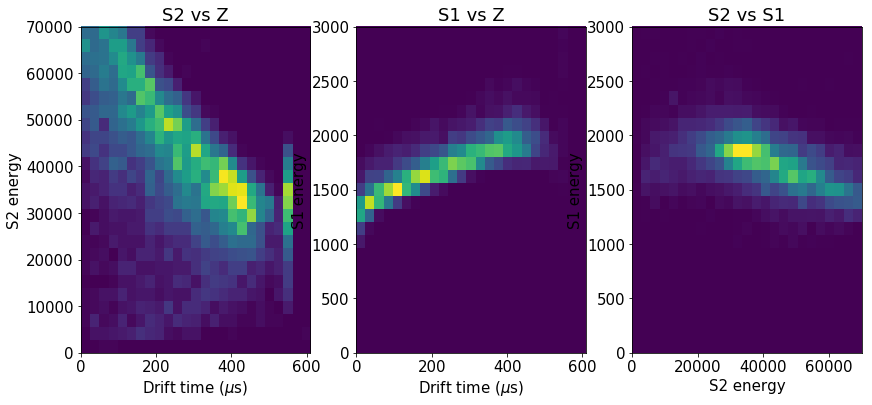

In [19]:
zrange =   0, 610
S2range = 0, 7e4
S1range = 0, 3e3

figsize=(14,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist2d(full.Z, full.S2e, (25, 25), range=(zrange, S2range))
labels("Drift time ($\mu$s)", "S2 energy")
plt.title('S2 vs Z')

ax = plt.subplot(1, 3, 2)
plt.hist2d(full.Z, full.S1e, (25, 25), range=(zrange, S1range))
labels("Drift time ($\mu$s)", "S1 energy")
plt.title('S1 vs Z')

ax = plt.subplot(1, 3, 3)
plt.hist2d(full.S2e, full.S1e, (25, 25), range=(S2range, S1range))
labels("S2 energy", "S1 energy")
plt.title('S2 vs S1')



### Fiducial volume

In [20]:
#core = blk[blk.R < 100]
core = full[full.R < 100]
print("Ratio wrt full:", len(core)/len(full))

Ratio wrt full: 0.24110416217381928


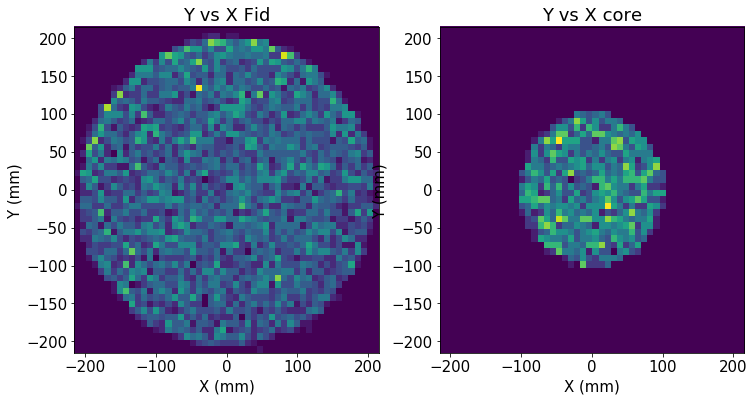

In [21]:
xrange = -215, 215
yrange = -215, 215

figsize=(12,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)

plt.hist2d(full.X, full.Y, (50, 50), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X Fid')

ax = plt.subplot(1, 2, 2)

plt.hist2d(core.X, core.Y, (50, 50), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X core')

### Z correction for bulk 

#### S2

fit par[0] = 77355.31713692979 error = 1289.4474134606662
fit par[1] = -567.4114124709513 error = 19.680865569400094
degrees of freedom = 2
chi2 = 4.354318233044534


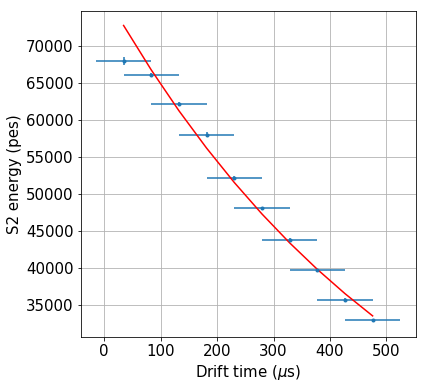

In [22]:
zrange =   10, 500
Erange = 1e+3, 70e3
nbins = 10
F, x, y, sy = profile_and_fit(core.Z, core.S2e, 
                    xrange=zrange, 
                    yrange=Erange, 
                    nbins=nbins, 
                    fitpar=(50000,-300), label=("Drift time ($\mu$s)", "S2 energy (pes)"))

print_fit(F)
print('chi2 = {}'.format(chi2(F, x, y, sy)))

#### Constrain fiducial in z

In [23]:
cz = core[in_range(core.Z ,25, 525)]
print("Ratio wrt full:", len(cz)/len(full))

Ratio wrt full: 0.2143627345266336


#### Fit S2 in fiducial 

fit par[0] = 77170.75559000752 error = 1140.1642330330728
fit par[1] = -567.1365492878806 error = 17.447216187828356
degrees of freedom = 2
chi2 = 4.1975714904293975


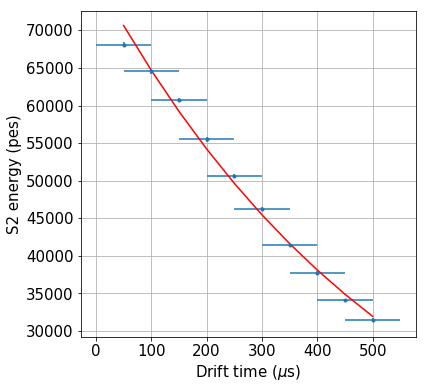

In [24]:
zrange =   25, 525
Erange = 1e+3, 70e3
nbins = 10
F, x, y, sy = profile_and_fit(cz.Z, cz.S2e, 
                    xrange=zrange, 
                    yrange=Erange, 
                    nbins=nbins, 
                    fitpar=(50000,-300), label=("Drift time ($\mu$s)", "S2 energy (pes)"))

print_fit(F)
print('chi2 = {}'.format(chi2(F, x, y, sy)))

### S2 corrections

In [25]:
st0 = time_from_timestamp(full.time[0])
st1 = time_from_timestamp(full.time[-1:])
print('t0 = {} t1 = {}'.format(st0,st1))

t0 = 2017-04-19 21:16:12 t1 = 2017-04-19 21:50:20


In [26]:
len(cz)

1988

using data set with length 1988
t0 = 2017-04-19 21:16:12 (index = 0) t1 = 2017-04-19 21:50:19 (index = 1988)
bin length = 397
 ---fit over events between 0 and 397
time0 = 2017-04-19 21:16:12 time1 = 2017-04-19 21:22:21
size of time leg = 397
fit par[0] = 83964.80421541944 error = 1759.1169591624073
fit par[1] = -525.9476618149091 error = 22.723601936513447
degrees of freedom = 2
chi2 = 1.7359137861544471
 ---fit over events between 397 and 794
time0 = 2017-04-19 21:22:21 time1 = 2017-04-19 21:29:34
size of time leg = 397
fit par[0] = 84065.51725748627 error = 1101.1497591504603
fit par[1] = -516.1171610053179 error = 13.211541417660577
degrees of freedom = 2
chi2 = 1.2405278794105399
 ---fit over events between 794 and 1191
time0 = 2017-04-19 21:29:34 time1 = 2017-04-19 21:36:41
size of time leg = 397
fit par[0] = 81101.3373229269 error = 473.29771186697246
fit par[1] = -525.2407027413016 error = 6.173152354085692
degrees of freedom = 2
chi2 = 0.4434280953853785
 ---fit over events be

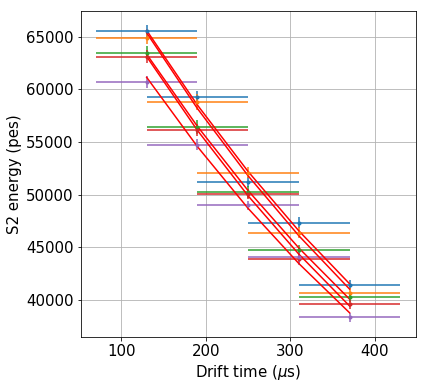

In [35]:
CHI2, LAMBDA, ELAMBDA, TSTAMP, TIME = lifetime(dst=cz, zrange=(100,400), Erange=(1e+3, 80e3), nbins=5)

In [36]:
plot_options()

In [37]:
TSTAMP

['2017-04-19 21:22:21',
 '2017-04-19 21:29:34',
 '2017-04-19 21:36:41',
 '2017-04-19 21:43:19',
 '2017-04-19 21:50:17']

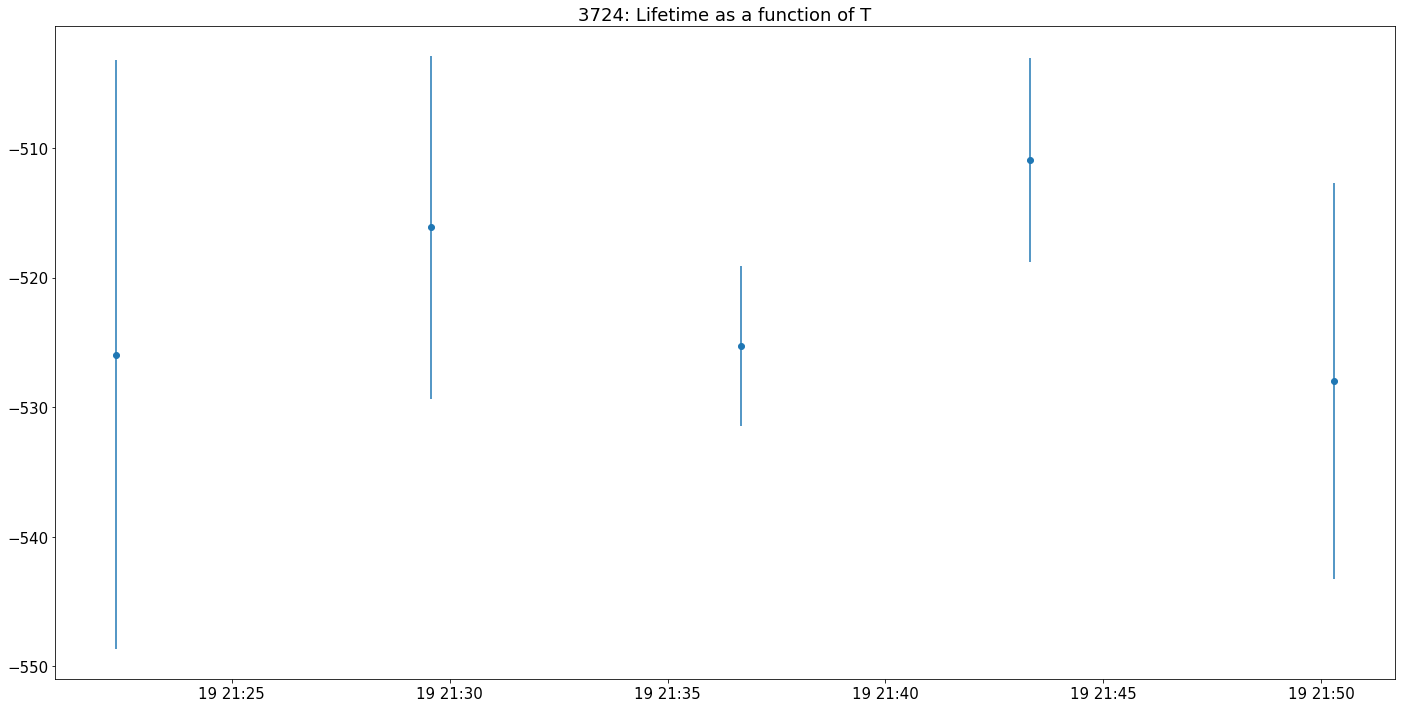

In [38]:
figsize=(24,12)
plt.figure(figsize=figsize)
plt.errorbar(TIME, LAMBDA, yerr=ELAMBDA, linestyle='none', fmt='o')
plt.title('{}: Lifetime as a function of T'.format(run_number))